In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
data = np.load('/content/drive/MyDrive/data.npy')
labels = np.load('/content/drive/MyDrive/labels.npy')

In [ ]:
 #setting numpy and tensor flow seed to ensure reproducibility of the results
import tensorflow as tf

# Set the seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## **Transfer Learning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
data = np.load('/content/drive/MyDrive/data.npy')
labels = np.load('/content/drive/MyDrive/labels.npy')

In [ ]:
 #setting numpy and tensor flow seed to ensure reproducibility of the results
import tensorflow as tf

# Set the seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Preprocessing Steps



## Splitting Data

In [ ]:
np.unique(labels)

array(['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
       'Viral Pneumonia'], dtype='<U22')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.2, stratify=labels, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= 0.25, stratify=y_train, random_state=42) #split 0.25 this time, because 0.25*0.8 = a 0.2 split for validation
print(str(X_train.shape[0]) + ' train samples')
print(str(X_validation.shape[0]) + ' validation samples')
print(str(X_test.shape[0]) + ' test samples')

3834 train samples
1279 validation samples
1279 test samples


## Normalize Data

In [ ]:
# encode Y class values as integers
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_validation = encoder.transform(y_validation)
y_test = encoder.transform(y_test)

In [ ]:
# Converting to categorical
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train) 
y_validation_cat = to_categorical(y_validation) 
y_test_cat = to_categorical(y_test)

In [ ]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_validation = X_validation.astype('float32')
X_test = X_test.astype('float32')

# Normalizing x values to 0-1
X_train = X_train / 255.0
X_validation = X_validation / 255.0
X_test = X_test / 255.0

In [ ]:
X_train.shape

(3834, 156, 156, 3)

## **VGG16**
>https://arxiv.org/abs/1409.1556 ---> paper that introduced VGG16 with 4k+ citations

>https://www.hindawi.com/journals/mpe/2021/9929274/ --> why we decided to use VGG16 instead of Resnet50. It's a paper where they also treat COVID and pneumonia images using VGG16

 >https://arxiv.org/abs/2003.11055-->Observe the VGG16 on similar data 
 
 Hemdan EE-D, Shouman MA, Karar ME. Covidx-net: a framework of deep
learning classifiers to diagnose covid-19 in x-ray images. arXiv preprint arXiv:
2003.11055, 2020.

>https://www.sciencedirect.com/science/article/abs/pii/S0950705115000179 -->Understanding the Transfer learning techniques

Transfer learning using computational intelligence: A survey
Jie Lu, Vahid Behbood, Peng Hao, Hua Zuo, Shan Xue, Guangquan Zhang


# **Transfer Learning**

Model 1

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import layers
from keras.models import Model
from keras.utils import to_categorical


# Load pre-trained model
model = VGG16( include_top=False, input_shape=(156, 156, 3))

for layer in model.layers:
	layer.trainable = False



flat1 = layers.Flatten()(model.layers[-1].output)
#add Dense layer
class1 = layers.Dense(156, activation='relu')(flat1)
#add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

# Convert target labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_validation = to_categorical(y_validation, num_classes=4)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #not binary we have 4 classes"

# Train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=25, batch_size=32, verbose=1)


58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 156, 156, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 156, 156, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 156, 156, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                              

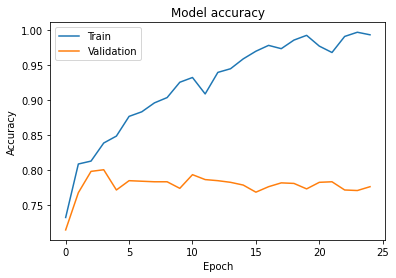

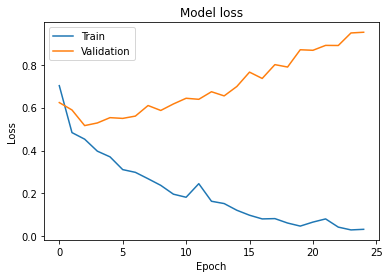

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_validation, y_validation_cat)
print(test_acc)

40/40 [==============================] - 3s 69ms/step - loss: 0.9516 - accuracy: 0.7764
0.7763878107070923


Model 2 

In [ ]:
#VGG16 Dropout

from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import layers
from keras.models import Model
from keras.utils import to_categorical


# Load pre-trained model
model = VGG16( include_top=False, input_shape=(156, 156, 3))

for layer in model.layers:
    layer.trainable = False

flat1 = layers.Flatten()(model.layers[-1].output)
# Add Dense layer
class1 = layers.Dense(156, activation='relu')(flat1)
# Add Dropout layer
dropout1 = layers.Dropout(0.5)(class1)
# Add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(dropout1)
# Define new model
model = Model(inputs=model.inputs, outputs=output)



# Recompile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train_cat, validation_data=(X_validation, y_validation_cat), epochs=15, batch_size=32, verbose=1)



Epoch 1/15
120/120 [==============================] - 14s 100ms/step - loss: 0.7811 - accuracy: 0.6821 - val_loss: 0.5761 - val_accuracy: 0.7772
Epoch 2/15
120/120 [==============================] - 11s 93ms/step - loss: 0.6094 - accuracy: 0.7480 - val_loss: 0.5788 - val_accuracy: 0.7647
Epoch 3/15
120/120 [==============================] - 14s 114ms/step - loss: 0.5556 - accuracy: 0.7660 - val_loss: 0.5211 - val_accuracy: 0.7998
Epoch 4/15
120/120 [==============================] - 11s 93ms/step - loss: 0.5226 - accuracy: 0.7879 - val_loss: 0.5296 - val_accuracy: 0.7912
Epoch 5/15
120/120 [==============================] - 14s 113ms/step - loss: 0.5205 - accuracy: 0.7780 - val_loss: 0.5083 - val_accuracy: 0.7936
Epoch 6/15
120/120 [==============================] - 14s 113ms/step - loss: 0.4932 - accuracy: 0.7963 - val_loss: 0.5062 - val_accuracy: 0.8022
Epoch 7/15
120/120 [==============================] - 14s 113ms/step - loss: 0.4769 - accuracy: 0.8083 - val_loss: 0.5059 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(X_validation, y_validation)
print(test_acc)

40/40 [==============================] - 3s 71ms/step - loss: 0.5818 - accuracy: 0.7998
0.7998436093330383


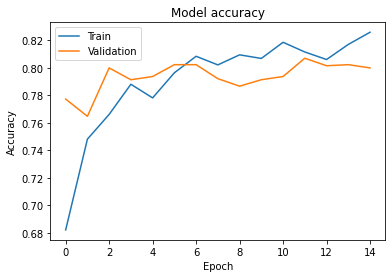

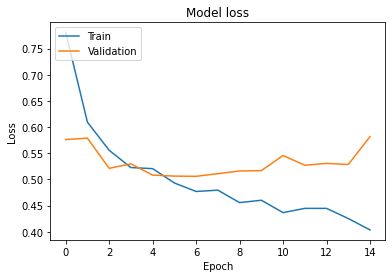

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model 3
>https://www.sciencedirect.com/science/article/pii/S0893608098000100?casa_token=-LLQlBYYfVIAAAAA:gbmW_MYGp6IqLrvUIOPSy1wT8kfua5B7iJDXrKP_YEzv3xxEL5P8aGPiLufjABIqupku0OLQdkDU --> early stopping
> >https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer, --> dropout

In [ ]:
#VGG16 Dropout and Early Stopping
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import layers
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load pre-trained model
model = VGG16( weights="imagenet",include_top=False, input_shape=(X_train[0].shape))


for layer in model.layers:
    layer.trainable = False

flat1 = layers.Flatten()(model.layers[-1].output)
# Add Dense layer
class1 = layers.Dense(156, activation='relu')(flat1)
# Add Dropout layer
dropout1 = layers.Dropout(0.5)(class1)
# Add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(dropout1)
# Define new model
model = Model(inputs=model.inputs, outputs=output)


from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = model.fit(X_train, y_train_cat, validation_data=(X_validation, y_validation_cat), epochs=15, batch_size=32, callbacks=[es])


Epoch 1/15
120/120 [==============================] - 16s 122ms/step - loss: 0.8180 - accuracy: 0.6625 - val_loss: 0.6161 - val_accuracy: 0.7780
Epoch 2/15
120/120 [==============================] - 14s 114ms/step - loss: 0.6282 - accuracy: 0.7340 - val_loss: 0.5634 - val_accuracy: 0.7787
Epoch 3/15
120/120 [==============================] - 14s 115ms/step - loss: 0.5824 - accuracy: 0.7668 - val_loss: 0.5396 - val_accuracy: 0.7928
Epoch 4/15
120/120 [==============================] - 14s 113ms/step - loss: 0.5556 - accuracy: 0.7647 - val_loss: 0.5424 - val_accuracy: 0.7952
Epoch 5/15
120/120 [==============================] - 14s 113ms/step - loss: 0.5305 - accuracy: 0.7820 - val_loss: 0.5152 - val_accuracy: 0.7944
Epoch 6/15
120/120 [==============================] - 13s 112ms/step - loss: 0.5067 - accuracy: 0.7942 - val_loss: 0.5133 - val_accuracy: 0.7936
Epoch 7/15
120/120 [==============================] - 11s 93ms/step - loss: 0.4943 - accuracy: 0.7916 - val_loss: 0.5224 - val_acc

In [ ]:
test_loss, test_acc = model.evaluate(X_validation, y_validation_cat)
print(test_acc)

40/40 [==============================] - 3s 68ms/step - loss: 0.5398 - accuracy: 0.7975
0.7974980473518372


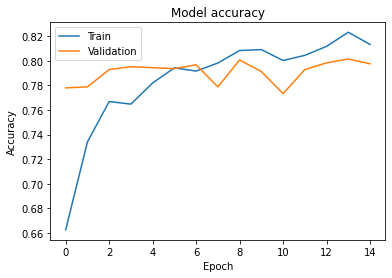

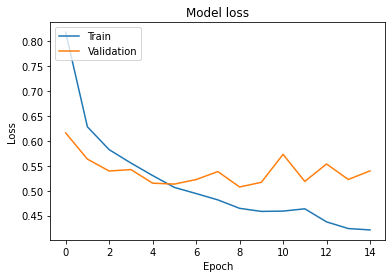

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

40/40 [==============================] - 3s 65ms/step


<AxesSubplot:>

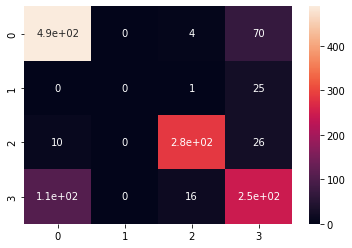

In [ ]:
# Note: adapted from here: https://colab.research.google.com/drive/1WEZxybgoxQz8Lmp_r6Zq6OHYdvwaz2Df?usp=sharing#scrollTo=tUtN6d9keAQn

import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predicting the validation set results confusion matrix
y_pred = model.predict(X_validation)

# Making the Confusion Matrix
cm = confusion_matrix(y_validation_cat.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True)

40/40 [==============================] - 3s 65ms/step


<AxesSubplot:>

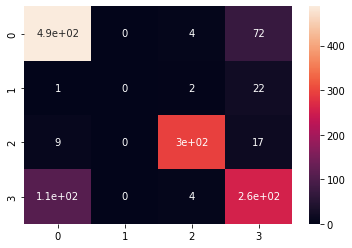

In [ ]:
# Predicting the Test set results confusion matrix
y_pred = model.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))

sns.heatmap(cm, annot=True)

40/40 [==============================] - 3s 66ms/step


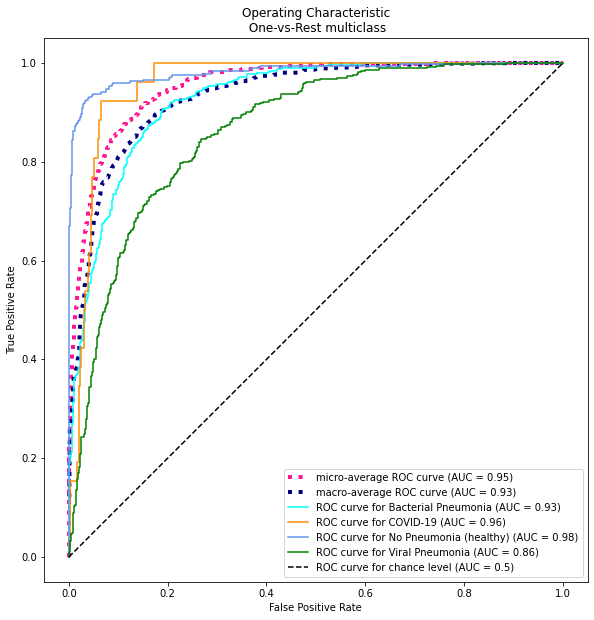

In [ ]:
###### you have to double check here that the labels and the classes 0,1,2,3 for now assume that it's correct

# ROC validation

# ROC curves need more research One vs one???
# Check here when you have more time: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_validation)
n_classes = len(np.unique(labels))

fig, ax = plt.subplots(figsize=(10, 10))

#Adding micro average to the plot
fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_validation_cat.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Adding macro average to the plot, taken from here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_validation_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr_grid = np.linspace(0.0, 1.0, 1000)
# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
# Average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

#Adding class specific ROC curves to the plot
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_validation_cat[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {np.unique(labels)[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Operating Characteristic\n One-vs-Rest multiclass")
plt.legend()
plt.show()

40/40 [==============================] - 3s 67ms/step


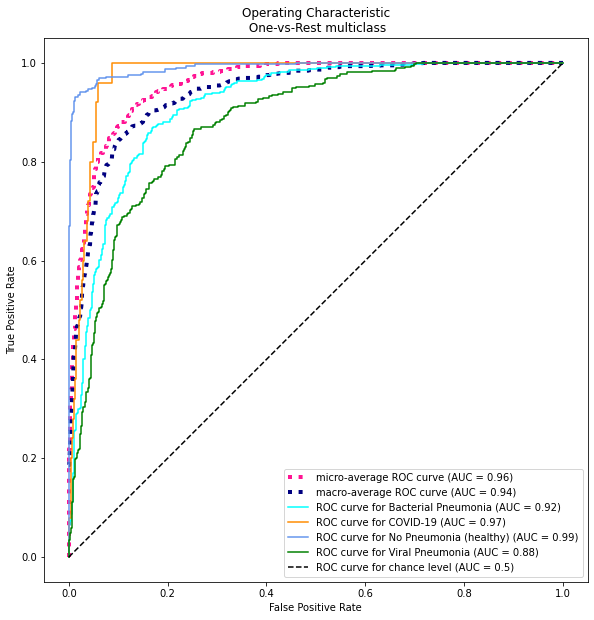

In [ ]:
# ROC Test

# ROC curves need more research One vs one???
# Check here when you have more time: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test)
n_classes = len(np.unique(labels))

fig, ax = plt.subplots(figsize=(10, 10))

#Adding micro average to the plot
fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Adding macro average to the plot, taken from here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr_grid = np.linspace(0.0, 1.0, 1000)
# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
# Average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

#Adding class specific ROC curves to the plot
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_cat[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {np.unique(labels)[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Operating Characteristic\n One-vs-Rest multiclass")
plt.legend()
plt.show()

In [ ]:
y_before = model.predict(X_test)
y_pred = y_before.argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)

import pandas as pd

from sklearn.metrics import precision_recall_fscore_support
res = []
for l, name in zip(range(n_classes),np.unique(labels)):
    prec,recall,fscore,_ = precision_recall_fscore_support(np.array(y_true)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None, beta=1)
    res.append([name,recall[0],recall[1],fscore[0]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity', 'f1score'])

40/40 [==============================] - 3s 73ms/step


,class,sensitivity,specificity,f1score
0,Bacterial Pneumonia,0.80000,0.875887,0.843036
1,COVID-19,1.00000,0.040000,0.990521
2,No Pneumonia (healthy),0.97286,0.919003,0.972860
3,Viral Pneumonia,0.89011,0.596206,0.866774
